In [1]:
'''
Nicole Osayande
261042925
Bzdok Lab MILA
'''
import os
import aesara
import scipy as sp
import arviz as az
import numpy as np
import pymc3 as pm
import pandas as pd
import xarray as xr
import seaborn as sns
from theano import shared
import arviz.labels as azl
from scipy.stats import zscore
from theano import tensor as tt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
#investigating fluid cognition and neighbourhood poverty occurrence
data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/abcd_nda3_manuscript.csv', usecols=['nihtbx_fluidcomp_uncorrected','reshist_addr1_adi_pov','abcd_site','site_id_l','race_ethnicity'], index_col=False)
print(data.shape)

(10843, 5)


In [3]:
val=data['reshist_addr1_adi_pov'].median()
data.loc[data['reshist_addr1_adi_pov'] <= val, 'reshist_addr1_adi_pov_bin'] = 0
data.loc[data['reshist_addr1_adi_pov'] > val, 'reshist_addr1_adi_pov_bin'] = 1 # poverty occurrence indicator

In [4]:
data['nihtbx_fluidcomp_uncorrected_log']= np.log(data['nihtbx_fluidcomp_uncorrected'])
col='nihtbx_fluidcomp_uncorrected_log'
data['nihtbx_fluidcomp_uncorrected_zscore'] = (data[col] - data[col].mean())/data[col].std(ddof=0)

In [5]:
race_idxs, race = pd.factorize(data.race_ethnicity)
data['race_enc'] = race_idxs #for shared object

state_idxs, state = pd.factorize(data.site_id_l)
data['state_enc'] = state_idxs #for shared object

In [7]:
#get input variables for shared object
abcd_race = data.race_enc.values
abcd_state = data.state_enc.values
pov = data.reshist_addr1_adi_pov_bin.values
target_values = data.nihtbx_fluidcomp_uncorrected_zscore.values

In [8]:
#initialize shared objects for the model hierarchies and input variable 
abcd_race_ = shared(abcd_race)
abcd_state_ = shared(abcd_state)
pov_ = shared(pov)

In [9]:
#varying intercepts and varying slopes: 
#predicting fluid cognition scores from parental poverty occurrence 

RANDOM_SEED = 8924
np.random.seed(286)

coords = {"abcd_race": np.arange(len(race)),"abcd_state": np.arange(len(state))}


with pm.Model(coords=coords) as varying_intercept_slope:
    
    # Hyperparameters
    a = pm.Normal("a", mu=0.0, sigma=5.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5) 
   
    # Varying intercepts
    a_state = pm.Normal("a_state", mu=0.0, sigma=1.0, dims ='abcd_state')

    # Varying slopes
    b_race = pm.Normal("b_race", mu=0.0, sigma=1.0, dims ='abcd_race')
    

    # Expected value per city, theta
    # Non-centered reparameterization 
    theta = (a + a_state[abcd_state_] * sigma_a) + (b + b_race[abcd_race_] * sigma_b) * pov_
    
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    likelihood = pm.Normal("likelihood", theta, sigma=sigma, observed=target_values)
    
with varying_intercept_slope:
    varying_intercept_slope_idata = pm.sample(2000,
        tune=3000, init="adapt_diag", target_accept=0.99, random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_race, a_state, sigma_b, b, sigma_a, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 1088 seconds.
The number of effective samples is smaller than 25% for some parameters.


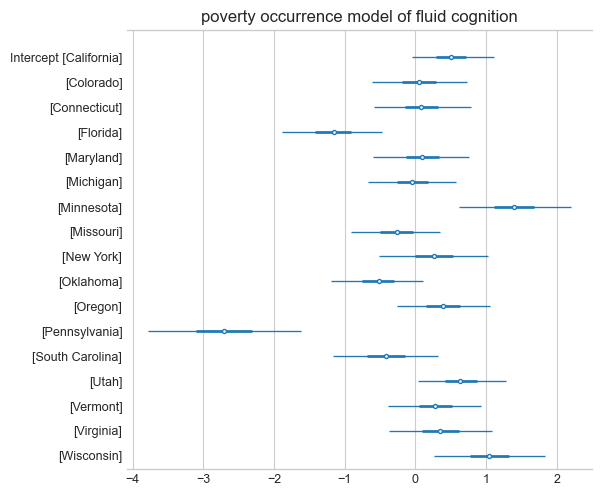

In [33]:
coords = {"abcd_state": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]}
var_names = ["a_state"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"a_state": "Intercept "}
coord_map = {"abcd_state": { 0:'California', 1:'Colorado', 2:'Connecticut', 3:'Florida', 4:'Maryland',
       5:'Michigan', 6:'Minnesota', 7:'Missouri', 8:'New York', 9:'Oklahoma', 10:'Oregon',
       11:'Pennsylvania', 12:'South Carolina', 13:'Utah', 14:'Vermont', 15:'Virginia',
       16:'Wisconsin'}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes= az.plot_forest(varying_intercept_slope_idata, var_names=var_names,coords=coords,labeller=labeller,combined=True, textsize=9);
fig = axes.ravel()[0].figure
plt.title("poverty occurrence model of fluid cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
fig.savefig('forest_plot_state_intercept_pov_occur_fluid_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_63415/580219780.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


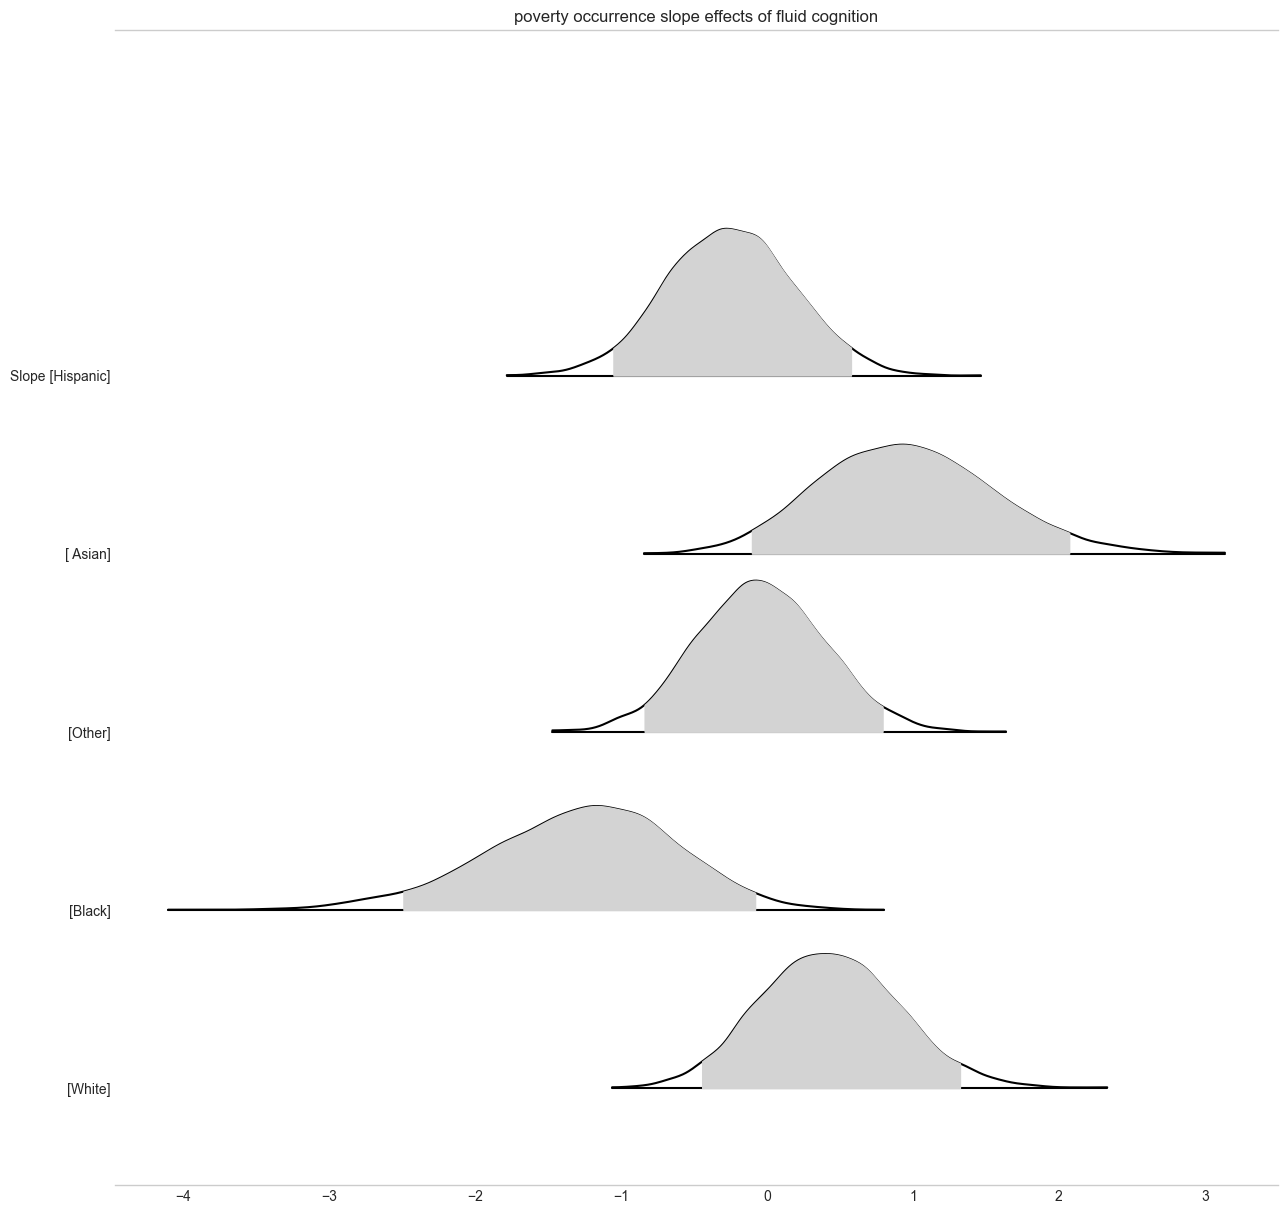

In [11]:
plt.style.use('seaborn-whitegrid')
coords = {"abcd_race": [0,1,2,3,4]}
var_names = ["b_race"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"b_race": "Slope "}
coord_map = {"abcd_race": { 0:"Hispanic", 1: " Asian", 2:"Other", 3:"Black", 4:"White"}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes = az.plot_forest(varying_intercept_slope_idata,
                           kind='ridgeplot',var_names=var_names,coords=coords,labeller=labeller,
                           combined=True,
                           ridgeplot_truncate=False,
                           ridgeplot_overlap=0.7,
                           colors='lightgrey',
                           figsize=(15, 15))
fig = axes.ravel()[0].figure
plt.title("poverty occurrence slope effects of fluid cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
fig.savefig('forest_ridge_plot_race_slope_pov_occur_fluid_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

In [12]:
with varying_intercept_slope:
    ppc = pm.sample_posterior_predictive(varying_intercept_slope_idata, var_names=["likelihood","a_state","b_race"], random_seed=RANDOM_SEED)
    

In [13]:
# Bayesian R2 score 
az.r2_score(target_values, ppc['likelihood'])

r2        0.358118
r2_std    0.003430
dtype: float64

In [14]:
#create ppc dataframe 
PP_COL = ['pp_cog_{}'.format(i) for i in range(ppc['likelihood'].shape[0])]
ppc_df = pd.DataFrame(ppc['likelihood'].T, columns=PP_COL)
ppc_df.shape

(10843, 8000)

In [15]:
# get race, state and poverty occurrence columns for ppc dataframe, reset index for merging dataframes
abcd_race_df = pd.DataFrame(data['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df = pd.DataFrame(data['site_id_l'],columns =['site_id_l']).reset_index(drop=True)
abcd_pov_df = pd.DataFrame(data['reshist_addr1_adi_pov_bin'],columns =['reshist_addr1_adi_pov_bin']).reset_index(drop=True)


In [16]:
ppc_df = pd.merge(abcd_race_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_state_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_pov_df,ppc_df,left_index=True, right_index=True)


In [17]:
ppc_pov_race_mean = (ppc_df.groupby(['reshist_addr1_adi_pov_bin','race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_pov_race_mean

pp_cog_0  pp_cog_1  pp_cog_2  \
reshist_addr1_adi_pov_bin race_ethnicity                                 
0.0                       Asian           0.194517  0.333579  0.208242   
                          Black           0.218922  0.117348  0.195690   
                          Hispanic        0.137758  0.179628  0.194164   
                          Other           0.200483  0.136536  0.188357   
                          White           0.232790  0.209192  0.220962   
1.0                       Asian           0.387978  0.461265  0.230772   
                          Black          -0.671488 -0.682435 -0.731972   
                          Hispanic       -0.204788 -0.246255 -0.217131   
                          Other          -0.123970 -0.156029 -0.187019   
                          White           0.142168  0.045824  0.109307   

                                          pp_cog_3  pp_cog_4  pp_cog_5  \
reshist_addr1_adi_pov_bin race_ethnicity                                 
0.0                       Asian           0.076327  0.205652  0.159368   
                          Black           0.192587  0.182256  0.197801   
                          Hispanic        0.105251  0.223140  0.133652   
                          Other           0.181276  0.187426  0.073395   
                          White           0.194835  0.255615  0.186220   
1.0                       Asian           0.460711  0.116599  0.240703   
                          Black          -0.697722 -0.677967 -0.747220   
                          Hispanic       -0.137932 -0.189067 -0.240713   
                          Other          -0.129942  0.015631 -0.120759   
                          White           0.077436  0.097349  0.075518   

                                          pp_cog_6  pp_cog_7  pp_cog_8  \
reshist_addr1_adi_pov_bin race_ethnicity                                 
0.0                       Asian           0.146525  0.226355  0.218127   
                          Black           0.194813  0.221215  0.131160   
                          Hispanic        0.170975  0.121949  0.161536   
                          Other           0.137012  0.158644  0.151548   
                          White           0.191957  0.208106  0.175984   
1.0                       Asian           0.318708  0.417784  0.230781   
                          Black          -0.744752 -0.768578 -0.719734   
                          Hispanic       -0.206685 -0.237237 -0.207602   
                          Other          -0.189638 -0.280457 -0.088841   
                          White           0.074985  0.088612  0.067553   

                                          pp_cog_9  ...  pp_cog_7990  \
reshist_addr1_adi_pov_bin race_ethnicity            ...                
0.0                       Asian           0.293779  ...     0.207852   
                          Black           0.172565  ...     0.135939   
                          Hispanic        0.197334  ...     0.158090   
                          Other           0.153462  ...     0.135855   
                          White           0.217950  ...     0.218154   
1.0                       Asian           0.253940  ...    -0.055839   
                          Black          -0.701153  ...    -0.715497   
                          Hispanic       -0.150240  ...    -0.192500   
                          Other          -0.171587  ...    -0.078077   
                          White           0.106899  ...     0.076528   

                                          pp_cog_7991  pp_cog_7992  \
reshist_addr1_adi_pov_bin race_ethnicity                             
0.0                       Asian              0.150588     0.259795   
                          Black              0.128754     0.104871   
                          Hispanic           0.267318     0.208510   
                          Other              0.156840     0.147578   
                          White              0.191072     0.181415   
1.0                 

In [18]:
ppc_pov_race_mean_summ=ppc_pov_race_mean.mean(axis=1)
ppc_pov_race_mean_summ

reshist_addr1_adi_pov_bin  race_ethnicity
0.0                        Asian             0.220199
                           Black             0.159099
                           Hispanic          0.172112
                           Other             0.182706
                           White             0.206879
1.0                        Asian             0.347825
                           Black            -0.721173
                           Hispanic         -0.205921
                           Other            -0.140288
                           White             0.088450
dtype: float64

In [19]:
ppc_race_mean = (ppc_df.groupby(['race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_race_mean

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
race_ethnicity,,,,,,,,,,,,,,,,,,,,,
Asian,0.256555,0.374525,0.215467,0.199589,0.177095,0.185450,0.201740,0.287742,0.222185,0.281003,...,0.123293,0.174381,0.270149,0.181190,0.227943,0.433834,0.357445,0.298563,0.273128,0.150329
Black,-0.495389,-0.524259,-0.548505,-0.521642,-0.507838,-0.560320,-0.558931,-0.572823,-0.551450,-0.528354,...,-0.547105,-0.602309,-0.577184,-0.530159,-0.564091,-0.607278,-0.528315,-0.572862,-0.489003,-0.612042
Hispanic,-0.104519,-0.121592,-0.096738,-0.066748,-0.068408,-0.131130,-0.096138,-0.132097,-0.099549,-0.048499,...,-0.089877,-0.047881,-0.084398,-0.079216,-0.049550,-0.090588,-0.092315,-0.106248,-0.097026,-0.098687
Other,0.040122,-0.008065,0.002826,0.027456,0.102516,-0.022566,-0.024436,-0.058383,0.032735,-0.007194,...,0.030119,0.010927,0.043905,-0.008701,0.108856,-0.002708,0.060685,-0.027369,0.006584,0.014704
White,0.201147,0.152148,0.181975,0.153842,0.200352,0.147565,0.151113,0.166381,0.138122,0.179174,...,0.168701,0.148206,0.132083,0.174877,0.156175,0.145405,0.170204,0.190303,0.154677,0.152918


In [20]:
ppc_race_mean_summ = ppc_race_mean.mean(axis=1)

In [21]:
ppc_pov_state_mean = (ppc_df.groupby(['reshist_addr1_adi_pov_bin','site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_pov_state_mean_summ = ppc_pov_state_mean.mean(axis=1)


In [22]:
ppc_state_mean = (ppc_df.groupby(['site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_state_mean_summ = ppc_state_mean.mean(axis=1) #for the geomaps


In [23]:
ppc_pov_state_mean_summ_list=ppc_pov_state_mean_summ.to_numpy()
low_pov_state = ppc_pov_state_mean_summ_list[:17]
high_pov_state = ppc_pov_state_mean_summ_list[-17:]

In [24]:
mean_predictions_state = [low_pov_state,high_pov_state] 
  
# Create the pandas DataFrame 
mean_pred_state = pd.DataFrame(mean_predictions_state, columns=state) 
  
# print dataframe. 
mean_pred_state

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,0.243756,0.174934,0.179924,-0.012173,0.182193,0.158988,0.380614,0.125022,0.206750,0.086095,0.226067,-0.250792,0.101361,0.264456,0.209325,0.221833,0.326397
1,-0.082657,-0.059936,-0.239572,-0.388427,-0.400931,-0.185900,0.171611,-0.305004,-0.182587,-0.270897,0.041452,-0.788614,-0.364694,0.116935,0.083891,-0.185341,0.013263


In [25]:
ppc_pov_race_mean_summ_list=ppc_pov_race_mean_summ.to_numpy()
low_pov_race = ppc_pov_race_mean_summ_list[:5]
high_pov_race = ppc_pov_race_mean_summ_list[-5:]

In [26]:
# initialize list of lists 
mean_predictions_race = [low_pov_race,high_pov_race] 
  
# Create the pandas DataFrame 
mean_pred_race = pd.DataFrame(mean_predictions_race, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race

,Asian,Black,Hispanic,Other,White
0,0.220199,0.159099,0.172112,0.182706,0.206879
1,0.347825,-0.721173,-0.205921,-0.140288,0.088450


In [27]:
#auxiliary data
census_data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/census_poststrat_dataset.csv', usecols=['state','PovertyLT100_FPL_score','County_population','race_ethnicity'], index_col=False)
print(census_data.shape)

(1042, 4)


In [28]:
val = census_data['PovertyLT100_FPL_score'].median()
census_data.loc[census_data['PovertyLT100_FPL_score'] < val, 'PovertyLT100_FPL_score_bin'] = 0
census_data.loc[census_data['PovertyLT100_FPL_score'] >= val, 'PovertyLT100_FPL_score_bin'] = 1

In [29]:
census = (census_data.groupby(['state','race_ethnicity','PovertyLT100_FPL_score_bin']).County_population.agg(['sum']).reset_index())
census = census.rename(columns={'sum': 'freq'})
census

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq
0,california,Asian,0.0,767423
1,california,Asian,1.0,1067892
2,california,Black,0.0,3168044
3,california,Black,1.0,786431
4,california,Hispanic,0.0,6779394
...,...,...,...,...
136,wisconsin,Black,1.0,39628
137,wisconsin,Hispanic,0.0,88054
138,wisconsin,Other,0.0,183517
139,wisconsin,White,0.0,4001207


In [30]:
census['race_enc']=census['race_ethnicity']
census['race_enc'].replace(race,[0,1,2,3,4], inplace=True)
census['state_enc']=census['state']
census['state_enc'].replace(state,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], inplace=True)
census.head()

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,race_enc,state_enc
0,california,Asian,0.0,767423,1,0
1,california,Asian,1.0,1067892,1,0
2,california,Black,0.0,3168044,3,0
3,california,Black,1.0,786431,3,0
4,california,Hispanic,0.0,6779394,0,0


In [31]:
#fix theano shared tensor type error
census=census.astype({'PovertyLT100_FPL_score_bin':'uint8'})

In [34]:
#initialize poststrat vars
ps_abcd_race = census.race_enc.values
ps_abcd_state = census.state_enc.values
ps_pov = census.PovertyLT100_FPL_score_bin.values

#swap the model input variables 
abcd_race_.set_value(ps_abcd_race)
abcd_state_.set_value(ps_abcd_state)
pov_.set_value(ps_pov)

In [35]:
#re-run posterior predictive check with auxiliary census SDI data
with varying_intercept_slope:
    ppc2 = pm.sample_posterior_predictive(varying_intercept_slope_idata,var_names=['likelihood','a_state','b_race'],random_seed=RANDOM_SEED)
    

In [36]:
#create ppc dataframe 
PP_COL2 = ['pp_cog_{}'.format(i) for i in range(ppc2['likelihood'].shape[0])]
ppc_df2 = pd.DataFrame(ppc2['likelihood'].T, columns=PP_COL2)
ppc_df2.shape


(141, 8000)

In [37]:
censust=census
censust

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,race_enc,state_enc
0,california,Asian,0,767423,1,0
1,california,Asian,1,1067892,1,0
2,california,Black,0,3168044,3,0
3,california,Black,1,786431,3,0
4,california,Hispanic,0,6779394,0,0
...,...,...,...,...,...,...
136,wisconsin,Black,1,39628,3,16
137,wisconsin,Hispanic,0,88054,0,16
138,wisconsin,Other,0,183517,2,16
139,wisconsin,White,0,4001207,4,16


In [38]:
# get race, state, and neighbourhood poverty occurrence columns for ppc dataframe, reset index for merging dataframes
abcd_race_df2 = pd.DataFrame(censust['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df2 = pd.DataFrame(censust['state'],columns =['state']).reset_index(drop=True)
abcd_pov_df2 = pd.DataFrame(censust['PovertyLT100_FPL_score_bin'],columns =['PovertyLT100_FPL_score_bin']).reset_index(drop=True)


In [39]:
ppc_df2 = pd.merge(censust['freq'],ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_pov_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_race_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_state_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,767423,-0.667426,1.495823,-0.537161,0.547840,-0.892415,-0.197404,...,1.026201,0.299697,0.525683,-0.372950,0.528657,-1.180781,-0.801945,0.906499,1.550106,0.038369
1,california,Asian,1,1067892,1.652920,0.568429,1.398202,-0.053827,0.667141,0.676507,...,-1.001150,-1.822883,-1.188351,0.468787,-0.841005,0.438242,1.538120,1.449513,0.139475,0.850093
2,california,Black,0,3168044,-1.597420,-1.928101,-0.631297,0.763577,-0.508787,1.091461,...,1.417177,0.820559,0.118582,-0.740617,0.414838,-0.915590,0.946425,-0.318085,0.464319,0.835072
3,california,Black,1,786431,-0.294717,-0.919278,-1.011803,0.226302,0.040936,0.327940,...,0.879205,0.478426,-0.143657,-0.781042,-1.928051,0.770514,0.155360,-1.758479,-2.535438,0.144616
4,california,Hispanic,0,6779394,1.196139,1.128119,-0.852982,0.024294,0.949147,0.378838,...,0.525464,-0.013393,-0.034540,1.181293,-0.947900,0.377404,1.975891,0.016147,0.320448,0.771369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,wisconsin,Black,1,39628,-2.274046,0.618492,0.728810,0.075178,1.382894,1.558561,...,-1.496198,0.640553,0.399545,-0.843432,-2.292938,-0.549052,0.214767,-1.084929,-2.834090,0.025605
137,wisconsin,Hispanic,0,88054,-0.965875,0.710833,0.598049,0.448848,0.180284,-0.247811,...,0.895873,-0.036981,-0.381692,-0.267514,2.559474,0.875401,-0.163820,0.187097,0.152226,0.006366
138,wisconsin,Other,0,183517,0.608740,-0.073428,0.102252,-0.137168,0.720085,0.899670,...,0.480846,0.775292,0.528652,-0.407528,-0.517419,0.324672,-0.043541,1.923863,-0.493554,-1.178432
139,wisconsin,White,0,4001207,-1.309821,1.265799,0.092404,0.724612,1.073326,0.942162,...,0.332131,-0.676713,-0.142456,0.372363,1.011203,1.387474,0.949157,0.299688,1.286340,1.274291


In [40]:
#data-weighted for each category
ppc_poststrat_df = ppc_df2.groupby(['state','race_ethnicity','PovertyLT100_FPL_score_bin']).apply(lambda df: (df[PP_COL2]*df.freq.sum(axis=0)))
ppc_poststrat_df

pp_cog_0  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0   -5.121978e+05   
                          1                          1    1.765140e+06   
           Black          0                          2   -5.060698e+06   
                          1                          3   -2.317744e+05   
           Hispanic       0                          4    8.109096e+06   
...                                                                ...   
wisconsin  Black          1                          136 -9.011588e+04   
           Hispanic       0                          137 -8.504915e+04   
           Other          0                          138  1.117141e+05   
           White          0                          139 -5.240865e+06   
                          1                          140  4.150152e+05   

                                                              pp_cog_1  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0    1.147929e+06   
                          1                          1    6.070207e+05   
           Black          0                          2   -6.108308e+06   
                          1                          3   -7.229490e+05   
           Hispanic       0                          4    7.647966e+06   
...                                                                ...   
wisconsin  Black          1                          136  2.450961e+04   
           Hispanic       0                          137  6.259168e+04   
           Other          0                          138 -1.347522e+04   
           White          0                          139  5.064725e+06   
                          1                          140  1.170815e+05   

                                                              pp_cog_2  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0   -4.122299e+05   
                          1                          1    1.493129e+06   
           Black          0                          2   -1.999976e+06   
                          1                          3   -7.957135e+05   
           Hispanic       0                          4   -5.782698e+06   
...                                                                ...   
wisconsin  Black          1                          136  2.888127e+04   
           Hispanic       0                          137  5.266059e+04   
           Other          0                          138  1.876504e+04   
           White          0                          139  3.697290e+05   
                          1                          140  1.748927e+05   

                                                              pp_cog_3  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0    4.204252e+05   
                          1                          1   -5.748137e+04   
           Black          0                          2    2.419045e+06   
                          1                          3    1.779708e+05   
           Hispanic       0                          4    1.646980e+05   
...                                                                ...   
wisconsin  Black          1                          136  2.979146e+03   
           Hispanic       0                          137  3.952285e+04   
           Other          0                          138 -2.517261e+04   
           White          0                          139  2.899324e+06   
                          1                          140 -8.865304e+04   

                                                              pp_cog_4  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0   -6.84

In [41]:
#re-format groupby to remove multi-index
ppc_poststrat_df = ppc_poststrat_df.to_numpy()
ppc_poststrat_df = pd.DataFrame(ppc_poststrat_df, columns=PP_COL2)
ppc_poststrat_df

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,-5.121978e+05,1.147929e+06,-4.122299e+05,4.204252e+05,-6.848601e+05,-1.514927e+05,1.050183e+05,8.989368e+05,9.270898e+05,3.585506e+04,...,7.875306e+05,2.299945e+05,4.034215e+05,-2.862106e+05,4.057039e+05,-9.061586e+05,-6.154311e+05,6.956682e+05,1.189587e+06,2.944562e+04
1,1.765140e+06,6.070207e+05,1.493129e+06,-5.748137e+04,7.124346e+05,7.224362e+05,1.292416e+06,8.347271e+05,1.890033e+06,1.321174e+06,...,-1.069120e+06,-1.946642e+06,-1.269031e+06,5.006141e+05,-8.981026e+05,4.679952e+05,1.642546e+06,1.547924e+06,1.489439e+05,9.078071e+05
2,-5.060698e+06,-6.108308e+06,-1.999976e+06,2.419045e+06,-1.611858e+06,3.457797e+06,3.594444e+06,3.450762e+06,-2.044151e+06,9.524572e+05,...,4.489679e+06,2.599568e+06,3.756742e+05,-2.346306e+06,1.314224e+06,-2.900631e+06,2.998316e+06,-1.007706e+06,1.470984e+06,2.645545e+06
3,-2.317744e+05,-7.229490e+05,-7.957135e+05,1.779708e+05,3.219328e+04,2.579021e+05,-1.422004e+06,-8.525907e+05,-8.370465e+05,-1.042368e+06,...,6.914339e+05,3.762489e+05,-1.129765e+05,-6.142359e+05,-1.516279e+06,6.059562e+05,1.221799e+05,-1.382923e+06,-1.993947e+06,1.137308e+05
4,8.109096e+06,7.647966e+06,-5.782698e+06,1.646980e+05,6.434644e+06,2.568293e+06,5.960254e+06,-3.127511e+06,8.589879e+06,1.068292e+05,...,3.562326e+06,-9.079623e+04,-2.341579e+05,8.008453e+06,-6.426187e+06,2.558569e+06,1.339535e+07,1.094688e+05,2.172441e+06,5.229415e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,-9.011588e+04,2.450961e+04,2.888127e+04,2.979146e+03,5.480134e+04,6.176265e+04,-4.098120e+04,-1.290184e+04,-1.050038e+05,-4.541171e+04,...,-5.929134e+04,2.538382e+04,1.583316e+04,-3.342352e+04,-9.086455e+04,-2.175783e+04,8.510803e+03,-4.299358e+04,-1.123093e+05,1.014676e+03
137,-8.504915e+04,6.259168e+04,5.266059e+04,3.952285e+04,1.587471e+04,-2.182077e+04,6.207405e+04,1.125611e+05,1.442730e+04,1.647010e+05,...,7.888517e+04,-3.256325e+03,-3.360947e+04,-2.355566e+04,2.253719e+05,7.708254e+04,-1.442502e+04,1.647461e+04,1.340408e+04,5.605943e+02
138,1.117141e+05,-1.347522e+04,1.876504e+04,-2.517261e+04,1.321478e+05,1.651048e+05,2.533476e+05,6.161258e+04,-1.882701e+05,3.478093e+05,...,8.824346e+04,1.422792e+05,9.701663e+04,-7.478832e+04,-9.495515e+04,5.958287e+04,-7.990548e+03,3.530615e+05,-9.057563e+04,-2.162623e+05
139,-5.240865e+06,5.064725e+06,3.697290e+05,2.899324e+06,4.294598e+06,3.769785e+06,4.820283e+06,6.713596e+04,9.872539e+05,2.978126e+06,...,1.328925e+06,-2.707670e+06,-5.699957e+05,1.489900e+06,4.046033e+06,5.551572e+06,3.797775e+06,1.199114e+06,5.146912e+06,5.098702e+06


In [42]:
ppc_df2_sub = ppc_df2.iloc[:, : 4] #get the input var, race, state and freq columns, to perform another group by for the final posstratification step
ppc_df2_sub

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq
0,california,Asian,0,767423
1,california,Asian,1,1067892
2,california,Black,0,3168044
3,california,Black,1,786431
4,california,Hispanic,0,6779394
...,...,...,...,...
136,wisconsin,Black,1,39628
137,wisconsin,Hispanic,0,88054
138,wisconsin,Other,0,183517
139,wisconsin,White,0,4001207


In [43]:
ppc_poststrat_df = pd.merge(ppc_df2_sub,ppc_poststrat_df,left_index=True, right_index=True) #merge the extracted colums with the dataframe from the first step of poststratification
ppc_poststrat_df

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,767423,-5.121978e+05,1.147929e+06,-4.122299e+05,4.204252e+05,-6.848601e+05,-1.514927e+05,...,7.875306e+05,2.299945e+05,4.034215e+05,-2.862106e+05,4.057039e+05,-9.061586e+05,-6.154311e+05,6.956682e+05,1.189587e+06,2.944562e+04
1,california,Asian,1,1067892,1.765140e+06,6.070207e+05,1.493129e+06,-5.748137e+04,7.124346e+05,7.224362e+05,...,-1.069120e+06,-1.946642e+06,-1.269031e+06,5.006141e+05,-8.981026e+05,4.679952e+05,1.642546e+06,1.547924e+06,1.489439e+05,9.078071e+05
2,california,Black,0,3168044,-5.060698e+06,-6.108308e+06,-1.999976e+06,2.419045e+06,-1.611858e+06,3.457797e+06,...,4.489679e+06,2.599568e+06,3.756742e+05,-2.346306e+06,1.314224e+06,-2.900631e+06,2.998316e+06,-1.007706e+06,1.470984e+06,2.645545e+06
3,california,Black,1,786431,-2.317744e+05,-7.229490e+05,-7.957135e+05,1.779708e+05,3.219328e+04,2.579021e+05,...,6.914339e+05,3.762489e+05,-1.129765e+05,-6.142359e+05,-1.516279e+06,6.059562e+05,1.221799e+05,-1.382923e+06,-1.993947e+06,1.137308e+05
4,california,Hispanic,0,6779394,8.109096e+06,7.647966e+06,-5.782698e+06,1.646980e+05,6.434644e+06,2.568293e+06,...,3.562326e+06,-9.079623e+04,-2.341579e+05,8.008453e+06,-6.426187e+06,2.558569e+06,1.339535e+07,1.094688e+05,2.172441e+06,5.229415e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,wisconsin,Black,1,39628,-9.011588e+04,2.450961e+04,2.888127e+04,2.979146e+03,5.480134e+04,6.176265e+04,...,-5.929134e+04,2.538382e+04,1.583316e+04,-3.342352e+04,-9.086455e+04,-2.175783e+04,8.510803e+03,-4.299358e+04,-1.123093e+05,1.014676e+03
137,wisconsin,Hispanic,0,88054,-8.504915e+04,6.259168e+04,5.266059e+04,3.952285e+04,1.587471e+04,-2.182077e+04,...,7.888517e+04,-3.256325e+03,-3.360947e+04,-2.355566e+04,2.253719e+05,7.708254e+04,-1.442502e+04,1.647461e+04,1.340408e+04,5.605943e+02
138,wisconsin,Other,0,183517,1.117141e+05,-1.347522e+04,1.876504e+04,-2.517261e+04,1.321478e+05,1.651048e+05,...,8.824346e+04,1.422792e+05,9.701663e+04,-7.478832e+04,-9.495515e+04,5.958287e+04,-7.990548e+03,3.530615e+05,-9.057563e+04,-2.162623e+05
139,wisconsin,White,0,4001207,-5.240865e+06,5.064725e+06,3.697290e+05,2.899324e+06,4.294598e+06,3.769785e+06,...,1.328925e+06,-2.707670e+06,-5.699957e+05,1.489900e+06,4.046033e+06,5.551572e+06,3.797775e+06,1.199114e+06,5.146912e+06,5.098702e+06


In [44]:
#final step of poststratification - by race & poverty occurrence 
#data-weighted average
ppc_pov_race_poststrat = ppc_poststrat_df.groupby(['PovertyLT100_FPL_score_bin','race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_pov_race_poststrat


pp_cog_0  pp_cog_1  pp_cog_2  \
PovertyLT100_FPL_score_bin race_ethnicity                                 
0                          Asian           0.471725  0.317771  0.021891   
                           Black          -0.210181 -0.114469  0.233784   
                           Hispanic        0.930678  1.143858 -0.173393   
                           Other           0.920651  0.460340  0.286658   
                           White          -0.189433  0.873097 -0.711570   
1                          Asian           0.851370 -0.149634  0.919177   
                           Black          -0.347190 -0.398846 -1.002547   
                           Hispanic        0.627221 -0.772973  0.060917   
                           Other          -1.014424  0.625176 -0.182642   
                           White           0.117774  0.096210  0.156057   

                                           pp_cog_3  pp_cog_4  pp_cog_5  \
PovertyLT100_FPL_score_bin race_ethnicity                                 
0                          Asian          -0.010478 -0.471520  0.615917   
                           Black           0.325045  0.172833  0.539319   
                           Hispanic       -0.143840  0.223406  0.253765   
                           Other          -0.293237 -0.118492 -0.802488   
                           White           0.378363 -0.154814  0.471507   
1                          Asian           0.159183  0.374034  0.360706   
                           Black          -0.442230 -0.610710 -1.038681   
                           Hispanic       -0.549282  0.113345 -0.559148   
                           Other           0.296641  0.310333  0.062596   
                           White           0.500285  0.552346 -0.055718   

                                           pp_cog_6  pp_cog_7  pp_cog_8  \
PovertyLT100_FPL_score_bin race_ethnicity                                 
0                          Asian           0.932010 -0.127771 -0.427118   
                           Black           0.357210  0.186603  0.224911   
                           Hispanic        0.415731 -0.271642  0.505026   
                           Other           1.216940  0.549770 -0.390963   
                           White           0.148631  0.431932 -0.268151   
1                          Asian           0.804436  0.789856  0.367390   
                           Black          -0.829168 -0.512628 -0.901302   
                           Hispanic       -0.450340 -0.466602 -0.729940   
                           Other          -0.305124 -1.835718  0.190981   
                           White           0.188679  0.258710 -0.158985   

                                           pp_cog_9  ...  pp_cog_7990  \
PovertyLT100_FPL_score_bin race_ethnicity            ...                
0                          Asian           0.600106  ...    -0.089616   
                           Black           0.393901  ...     0.309492   
                           Hispanic        0.154923  ...     0.314807   
                           Other           0.442228  ...    -0.464037   
                           White          -0.232566  ...     0.562524   
1                          Asian           0.502899  ...     0.213466   
                           Black          -0.627129  ...    -0.402590   
                           Hispanic        0.205511  ...    -1.060922   
                           Other           0.205814  ...    -0.383871   
                           White           0.111813  ...    -0.568512   

                                           pp_cog_7991  pp_cog_7992  \
PovertyLT100_FPL_score_bin race_ethnicity                             
0                          Asian              0.090051     0.156328   
                           Black             -0.063949     0.088714   
                           Hispanic           0.221960     0.145379   
                           Other              0.838059     0.035876   
                           White     

In [45]:
#summarize race & poverty occurrence poststrat results
ppc_pov_race_poststrat_summ = ppc_pov_race_poststrat.mean(axis=1)
ppc_pov_race_poststrat_summ

PovertyLT100_FPL_score_bin  race_ethnicity
0                           Asian             0.122123
                            Black             0.144107
                            Hispanic          0.206510
                            Other             0.099397
                            White             0.146580
1                           Asian             0.325578
                            Black            -0.653712
                            Hispanic         -0.254752
                            Other            -0.124834
                            White             0.074917
dtype: float64

In [46]:
#final step postrat - by race
ppc_race_poststrat = ppc_poststrat_df.groupby(['race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_race_poststrat_summ = ppc_race_poststrat.mean(axis=1)
ppc_race_poststrat_summ


race_ethnicity
Asian       0.173693
Black      -0.047602
Hispanic   -0.030583
Other      -0.036294
White       0.110213
dtype: float64

In [47]:
#for the lollipops
#final step poststrat - by state & poverty occurrence
ppc_pov_state_poststrat = ppc_poststrat_df.groupby(['PovertyLT100_FPL_score_bin','state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_pov_state_poststrat_summ = ppc_pov_state_poststrat.mean(axis=1)
ppc_pov_state_poststrat_summ

PovertyLT100_FPL_score_bin  state        
0                           california       0.252640
                            colorado         0.167070
                            connecticut      0.183144
                            florida         -0.011255
                            maryland         0.175655
                            michigan         0.154311
                            minnesota        0.382261
                            missouri         0.122352
                            newyork          0.205114
                            oklahoma         0.079876
                            oregon           0.224970
                            pennsylvania    -0.247447
                            southcarolina    0.096454
                            utah             0.278904
                            vermont          0.216580
                            virginia         0.232949
                            wisconsin        0.330845
1                           california  

In [48]:
#for the geomaps
#final step poststrat - by state
ppc_state_poststrat = ppc_poststrat_df.groupby(['state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_state_poststrat_summ = ppc_state_poststrat.mean(axis=1)
ppc_state_poststrat_summ

state
california       0.158240
colorado         0.138912
connecticut      0.183144
florida         -0.170199
maryland         0.068234
michigan         0.090141
minnesota        0.355327
missouri         0.012584
newyork          0.062294
oklahoma        -0.043958
oregon           0.141659
pennsylvania    -0.281336
southcarolina   -0.101055
utah             0.254244
vermont          0.205204
virginia         0.176979
wisconsin        0.346430
dtype: float64

In [49]:
ppc_pov_state_poststrat_summ_list=ppc_pov_state_poststrat_summ.tolist()

In [50]:
#fill in missing value for connecticut
ppc_pov_state_poststrat_summ_list.insert(19,ppc_pov_state_mean_summ.iloc[19])

In [51]:
ppc_pov_state_poststrat_summ_list

[0.252639645413524,
 0.16706973823224996,
 0.1831438975523601,
 -0.011255019564091171,
 0.17565501078183296,
 0.1543105642583472,
 0.3822608951832294,
 0.1223523204272872,
 0.20511435107683296,
 0.07987631670699542,
 0.22497005019918384,
 -0.24744686049877573,
 0.09645372305543944,
 0.2789037590575756,
 0.21657995247690873,
 0.23294908874920642,
 0.33084452610905457,
 0.08638648779922,
 -0.08311092546923946,
 -0.2395722006702286,
 -0.31772440245426903,
 -0.5641650709140245,
 0.03134623284583139,
 0.23890632164633718,
 -0.07506173977952636,
 -0.06108809009313693,
 -0.07687692221622197,
 0.08960590206225123,
 -0.36308632065517554,
 -0.195362385181307,
 0.01477680408823138,
 0.12104387660772317,
 0.04211660806072447,
 0.4031623224301278]

In [52]:
low_pov_state_poststrat = ppc_pov_state_poststrat_summ_list[:17]
high_pov_state_poststrat = ppc_pov_state_poststrat_summ_list[-17:]

In [53]:
ppc_pov_race_poststrat_summ_list=ppc_pov_race_poststrat_summ.tolist()

In [54]:
low_pov_race_poststrat = ppc_pov_race_poststrat_summ_list[:5]
high_pov_race_poststrat = ppc_pov_race_poststrat_summ_list[-5:]

In [55]:
mean_predictions_state_ps = [low_pov_state_poststrat,high_pov_state_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_state_ps = pd.DataFrame(mean_predictions_state_ps, columns=state) 
  
# print dataframe. 
mean_pred_state_ps

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,0.252640,0.167070,0.183144,-0.011255,0.175655,0.154311,0.382261,0.122352,0.205114,0.079876,0.224970,-0.247447,0.096454,0.278904,0.216580,0.232949,0.330845
1,0.086386,-0.083111,-0.239572,-0.317724,-0.564165,0.031346,0.238906,-0.075062,-0.061088,-0.076877,0.089606,-0.363086,-0.195362,0.014777,0.121044,0.042117,0.403162


In [56]:
# initialize list of lists 
mean_predictions_race_ps = [low_pov_race_poststrat,high_pov_race_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_race_ps = pd.DataFrame(mean_predictions_race_ps, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race_ps

,Asian,Black,Hispanic,Other,White
0,0.122123,0.144107,0.206510,0.099397,0.146580
1,0.325578,-0.653712,-0.254752,-0.124834,0.074917


In [57]:
quantiles = [0.5]

# Calculate quantiles for each row (state)
quantiles_per_state = np.quantile(ppc_state_mean, quantiles, axis=1)
quantiles_per_state_ps = np.quantile(ppc_state_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_state = quantiles_per_state.flatten().tolist()
quantiles_state_ps = quantiles_per_state_ps.flatten().tolist()

quantiles_state,quantiles_state_ps

([0.05637673220298378,
  0.10230547387415698,
  0.018771537902080665,
  -0.29471970717972384,
  -0.07615169697679693,
  -0.009721283090571953,
  0.3279275683952726,
  -0.0835551140142694,
  0.010743972970723627,
  -0.10085228553433767,
  0.12394812953417833,
  -0.6915002507762429,
  -0.11939771062323733,
  0.1962861223318425,
  0.1673029059684893,
  0.028407658695913413,
  0.23585585504987788],
 [0.16277496065183636,
  0.13528073401268031,
  0.1787578969516039,
  -0.17223387856018713,
  0.07057888117359751,
  0.08853647373362974,
  0.35327698637865396,
  0.0035199347479834353,
  0.05609872249295679,
  -0.04732331523687472,
  0.13407286612366748,
  -0.27710628115504454,
  -0.09728673902542385,
  0.25989917011921315,
  0.205130525295729,
  0.16904411318465323,
  0.34641244690053397])

In [58]:
capitalized_states=['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']

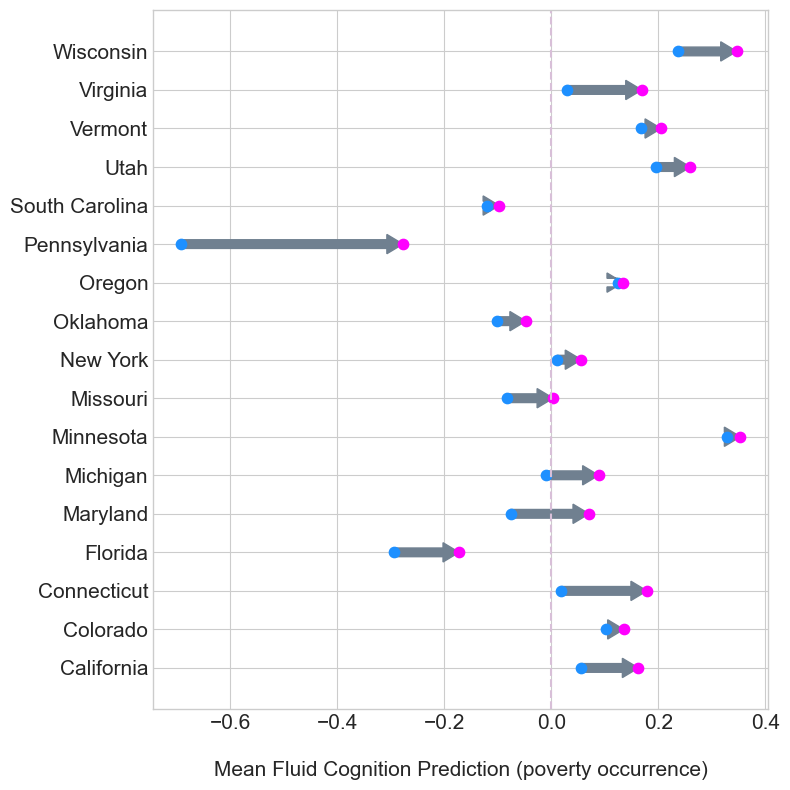

In [59]:
states = capitalized_states
quartiles_before_ps = quantiles_state   # mean prediction before poststratification
quartiles_after_ps = quantiles_state_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(8, 8))

# Plot arrows indicating change from before to after poststratification
for i in range(len(states)):
    plt.arrow(quartiles_before_ps[i], i, quartiles_after_ps[i] - quartiles_before_ps[i], 0, color='slategrey', width=0.225, head_width=0.5, head_length=0.03, length_includes_head=True)

# Plot second quartiles before poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_before_ps[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=55)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_after_ps[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=55)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(states)), states,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Fluid Cognition Prediction (poverty occurrence)',size=15,labelpad=20)
#plt.title('Mean Predictions of Fluid Cognition based on Poverty Occurrence Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
plt.savefig('arrow_plot_pov_occur_fluid_ps_state_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

In [60]:
quantiles_per_race = np.quantile(ppc_race_mean, quantiles, axis=1)
quantiles_per_race_ps = np.quantile(ppc_race_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_race = quantiles_per_race.flatten().tolist()
quantiles_race_ps = quantiles_per_race_ps.flatten().tolist()

quantiles_race,quantiles_race_ps

([0.2609422509449919,
  -0.5468399628823268,
  -0.09575276726444647,
  0.023271436166432735,
  0.1653439592697975],
 [0.17610139589056556,
  -0.05072408462716627,
  -0.030560739338180445,
  -0.032615425482107566,
  0.10857446369863025])

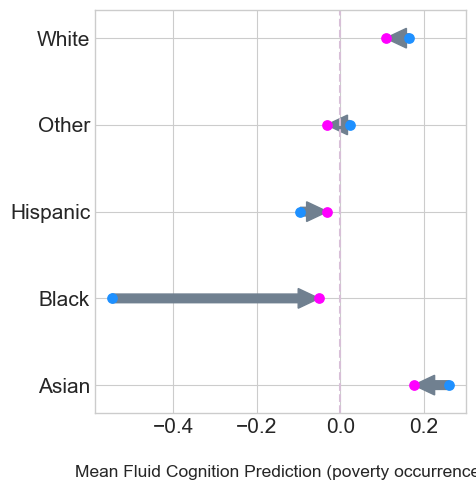

In [61]:
races = ['Asian','Black','Hispanic','Other','White']
quartiles_before_ps_r = quantiles_race   # mean prediction before poststratification
quartiles_after_ps_r = quantiles_race_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(5, 5))

# Plot arrows indicating change from before to after poststratification
for i in range(len(races)):
    plt.arrow(quartiles_before_ps_r[i], i, quartiles_after_ps_r[i] - quartiles_before_ps_r[i], 0, color='slategrey', width=0.10, head_width=0.227, head_length=0.05, length_includes_head=True)

# Plot second quartiles before poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_before_ps_r[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=45)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_after_ps_r[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=45)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(races)), races,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Fluid Cognition Prediction (poverty occurrence)',size=12.5,labelpad=20)
#plt.title('Mean Predictions of Fluid Cognition based on Poverty Occurrence Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
plt.savefig('arrow_plot_pov_occur_fluid_ps_race_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_63415/3383097302.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values, [state_name, state_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_63415/3383097302.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values2, [state_name2, state_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


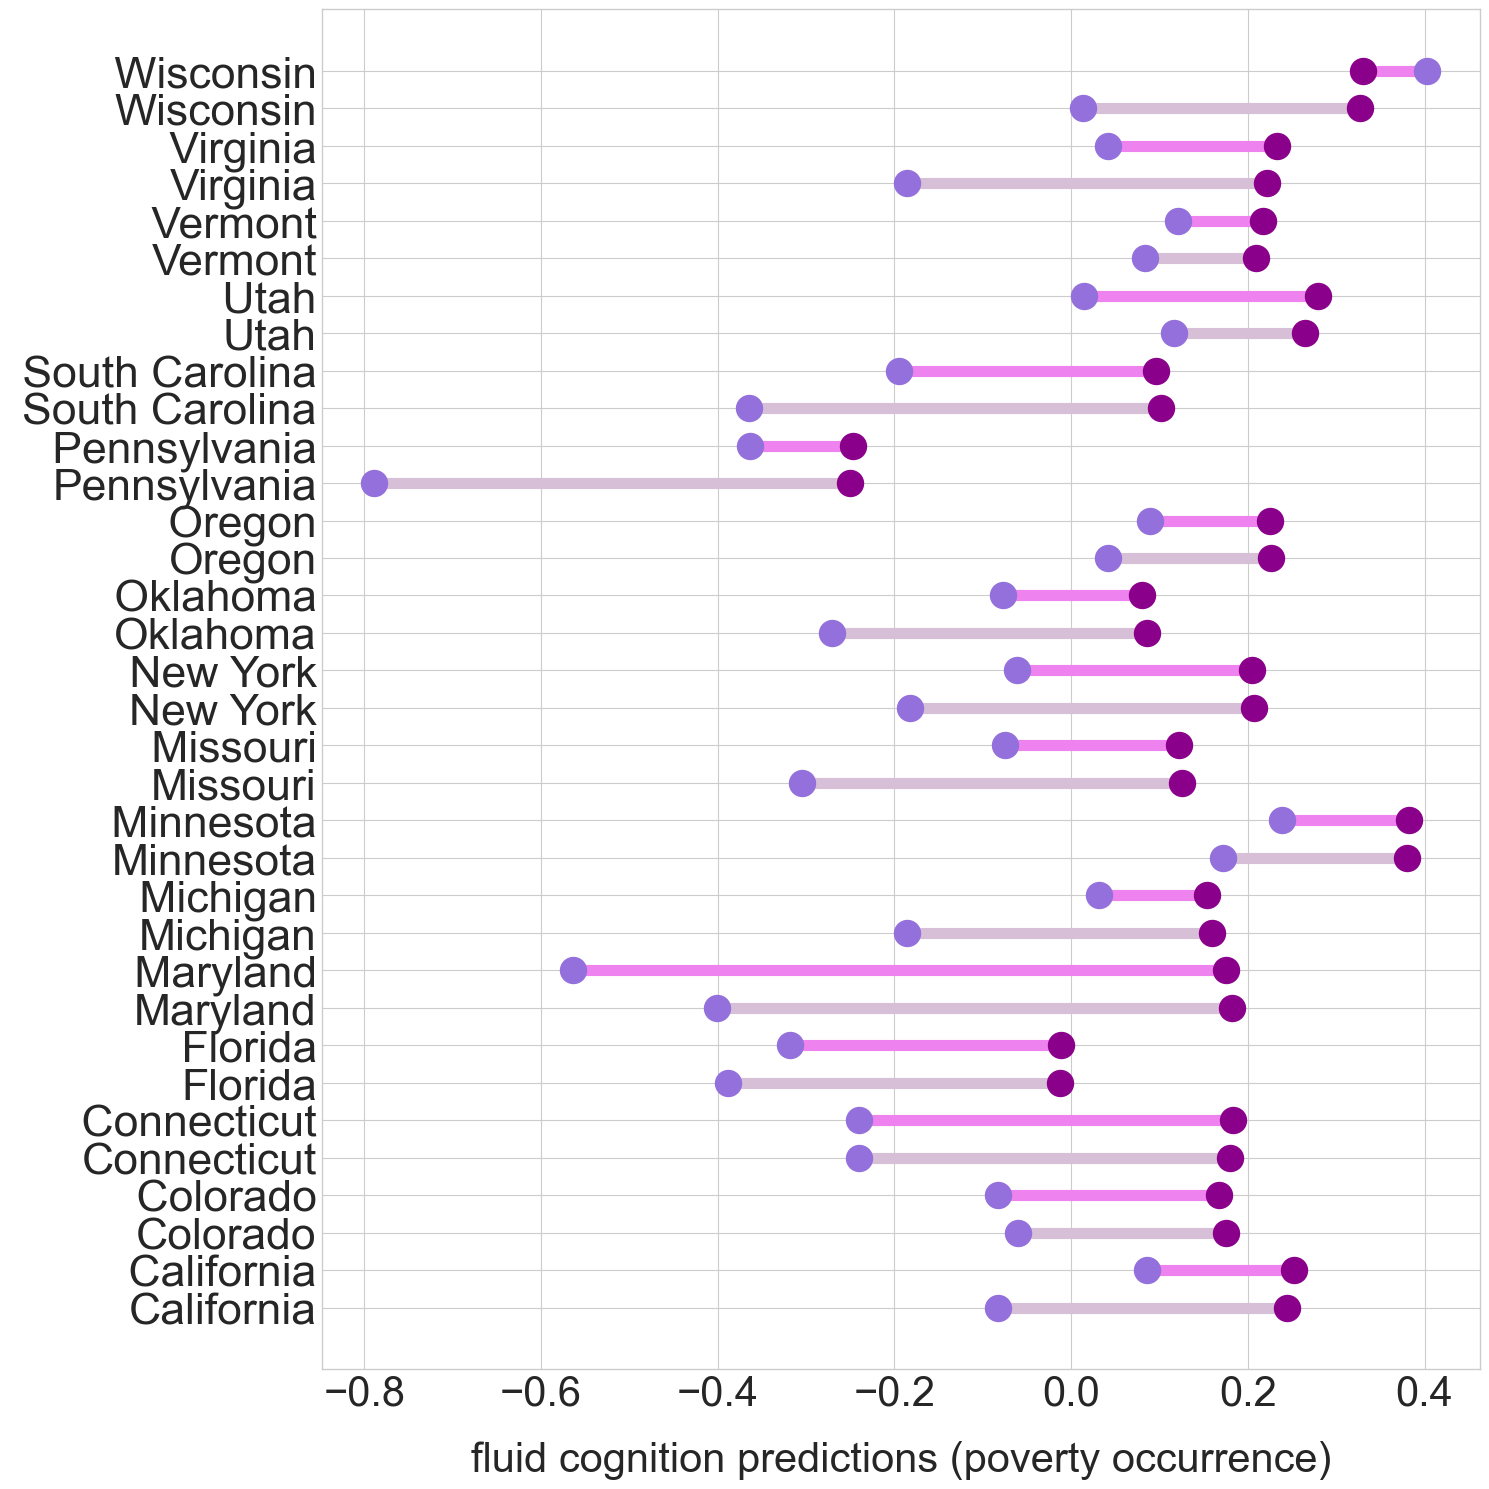

In [62]:
datas=mean_predictions_state
datas2=mean_predictions_state_ps
state_names = ['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']
state_names2 = [' California',
 ' Colorado',
 ' Connecticut',
 ' Florida',
 ' Maryland',
 ' Michigan',
 ' Minnesota',
 ' Missouri',
 ' New York',
 ' Oklahoma',
 ' Oregon',
 ' Pennsylvania',
 ' South Carolina',
 ' Utah',
 ' Vermont',
 ' Virginia',
 ' Wisconsin']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for state_name, state_values,state_name2, state_values2 in zip(state_names, np.array(datas).T,state_names2, np.array(datas2).T):
    plt.plot(state_values, [state_name, state_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(state_values2, [state_name2, state_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(state_values[0], state_name, color='darkmagenta', label='low pov oc', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values[1], state_name, color='mediumpurple', label='high pov oc', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(state_values2[0], state_name2, color='darkmagenta', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values2[1], state_name2, color='mediumpurple', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('fluid cognition predictions (poverty occurrence)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each State')
#plt.legend(['before PS','after PS','low pov oc', 'high pov oc'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig('lolli_plot_pov_occur_fluid_ps_state_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()


/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_63415/2286591492.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values, [race_name, race_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_63415/2286591492.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values2, [race_name2, race_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


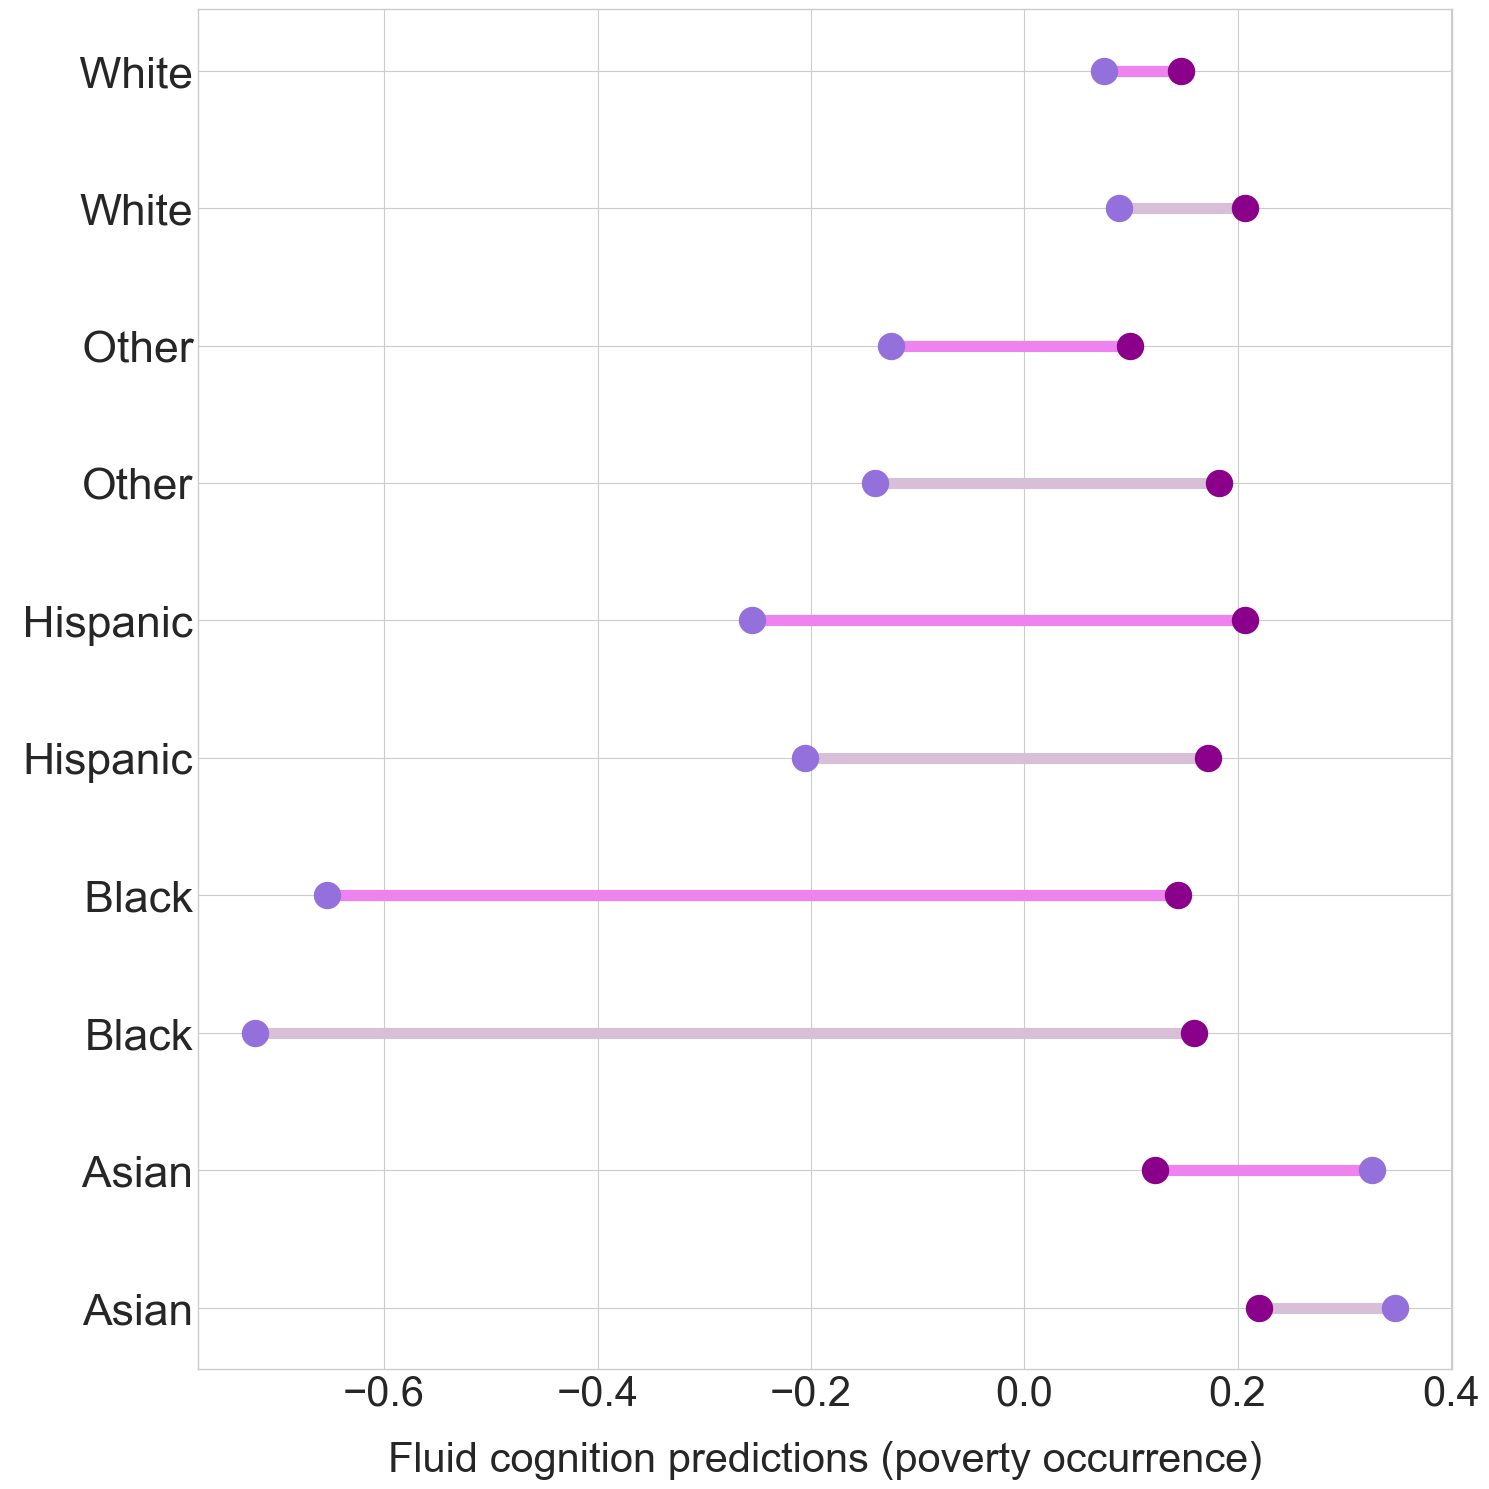

In [63]:
datas_r=mean_predictions_race
datas_r2=mean_predictions_race_ps
race_names = ['Asian',
 'Black',
 'Hispanic',
 'Other',
 'White']
#dont forget the blank space in front of the name so not overwritten
race_names2 = [' Asian',
 ' Black',
 ' Hispanic',
 ' Other',
 ' White']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for race_name, race_values,race_name2, race_values2 in zip(race_names, np.array(datas_r).T,race_names2, np.array(datas_r2).T):
    plt.plot(race_values, [race_name, race_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(race_values2, [race_name2, race_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(race_values[0], race_name, color='darkmagenta', label='low pov oc', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values[1], race_name, color='mediumpurple', label='high pov oc', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(race_values2[0], race_name2, color='darkmagenta', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values2[1], race_name2, color='mediumpurple', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Fluid cognition predictions (poverty occurrence)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each Race')
#plt.legend(['before PS','after PS','low pov oc', 'high pov oc'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig('lolli_plot_pov_occur_fluid_ps_race_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()